# Train 19-train_RNN_RNN_Wikipedia_geo_ratio_sc_0.5

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_

from tqdm import tqdm

from rouge_score import rouge_scorer

from utils_french.EmbMgr import EmbMgr
from utils_french.Dataset import Dataset
from utils_french.DataLoader import DataLoader
from utils_french.preprocess_df import preprocess_df
from utils_french.accuracy_nb_sent_per_doc import accuracy_nb_sent_per_doc_fn
from utils_french.accuracy_prop_sent_per_doc import accuracy_prop_sent_per_doc_fn
from utils_french.split_all_docs import split_all_docs

from models.RNN_RNN import RNN_RNN

from time import time

import json
import argparse

In [2]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## (Hyper-)parameters

In [4]:
# Parse args if script mode
parser = argparse.ArgumentParser(description='extractive summary')

parser.add_argument('-is_graphic',type=int,default=1,choices=[0,1])
parser.add_argument('-gpu_num',type=int,default=0)
parser.add_argument('-batch_size',type=int,default=32)
parser.add_argument('-epochs',type=int,default=100)

args = None

if is_notebook():
    args = parser.parse_args("")
else:
    args = parser.parse_args()

In [5]:
# parameters
is_graphic = args.is_graphic != 0
cuda_num = args.gpu_num
embed_name = "cc.fr.300.vec"

# hyper-parameters
vocab_size = 150000
batch_size = args.batch_size
epochs = args.epochs
learning_rate = 1e-3
early_stopping = 3
model_name = "19-train_RNN_RNN_Wikipedia_geo_ratio_sc_0.5"
sub_folder_name = "model_name__{}__time__{}__embed_name__{}__lr__{}__batch_size__{}__vocab_size__{}__cuda_num__{}".format(model_name, time(), embed_name, learning_rate, batch_size, vocab_size, cuda_num)
checkpoints_folder = "./checkpoints/" + sub_folder_name
average_number_of_sentences_per_document = 3

# print
print("parse:")
print("is_graphic:", is_graphic)
print("cuda_num:", cuda_num)
print("epochs", epochs)
print("batch_size", batch_size)

parse:
is_graphic: True
cuda_num: 0
epochs 100
batch_size 32


## PyTorch initialisation

In [6]:
# Check if a GPU is available
if torch.cuda.is_available():
    # Display the number of available GPUs
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    # Display the name of each GPU
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 6
GPU 0: NVIDIA GeForce GTX 1080 Ti
GPU 1: NVIDIA GeForce GTX 1080 Ti
GPU 2: NVIDIA GeForce GTX 1080 Ti
GPU 3: NVIDIA GeForce GTX 1080
GPU 4: NVIDIA GeForce GTX 1080
GPU 5: NVIDIA GeForce GTX 1080


In [7]:
if torch.cuda.is_available():  
  dev = "cuda:" + str(cuda_num) 
else:  
  dev = "cpu" 

device = torch.device(dev)
device

device(type='cuda', index=0)

## Chargement des données

In [8]:
embmgr = EmbMgr("./data/cc.fr.300.vec", vocab_size=vocab_size, header=True)

In [9]:

df_train = pd.read_json("./data/wiki_geo_ratio_sc_0.5/train.json")
train_dataset = Dataset(preprocess_df(df_train, glovemgr=embmgr, is_sep_n=False, doc_column_name="flat_contents", labels_column_name="labels_sentences", remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
train_iter = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
df_val = pd.read_json("./data/wiki_geo_ratio_sc_0.5/val.json")
val_dataset = Dataset(preprocess_df(df_val, glovemgr=embmgr, is_sep_n=False, doc_column_name="flat_contents", labels_column_name="labels_sentences", remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
val_iter = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

In [11]:
df_test = pd.read_json("./data/wiki_geo_ratio_sc_0.5/test.json")
test_dataset = Dataset(preprocess_df(df_test, glovemgr=embmgr, is_sep_n=False, doc_column_name="flat_contents", labels_column_name="labels_sentences", remove_stop_word=True, stemming=False, trunc_sent=50, padding_sent=50, trunc_doc=100))
test_iter = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

## Model

In [12]:
model = RNN_RNN(device=device, vocab_size=vocab_size, word_embed=embmgr.getEmbeddings(), dim_word_embed=300)

In [13]:
model.to(device)

RNN_RNN(
  (word_embedding): Embedding(150001, 300)
  (word_GRU): GRU(300, 200, batch_first=True, bidirectional=True)
  (sent_GRU): GRU(400, 200, batch_first=True, bidirectional=True)
  (rel_pos_emb): Embedding(11, 100)
  (abs_pos_emb): Embedding(100, 100)
  (Wdoc): Linear(in_features=400, out_features=400, bias=True)
  (Wcontent): Linear(in_features=400, out_features=1, bias=False)
  (Wsalience): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wnovelty): Bilinear(in1_features=400, in2_features=400, out_features=1, bias=False)
  (Wabs_pos): Linear(in_features=100, out_features=1, bias=False)
  (Wrel_pos): Linear(in_features=100, out_features=1, bias=False)
)

In [14]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adamax(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
mae_fn = nn.L1Loss()

## Train

In [15]:
if not os.path.exists(checkpoints_folder):
    os.makedirs(checkpoints_folder)

In [16]:
df_val["doc_splitted"] = split_all_docs(df_val["flat_contents"], is_sep_n = False)
val_set = df_val
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [17]:
arr_train_loss = []
arr_train_mae = []
arr_train_acc = []
arr_val_loss = []
arr_val_mae = []
arr_val_acc = []

t1 = time()
for epoch in range(1, epochs+1):
    # train 1 epoch
    model.train()
    nb_batch_train = 0
    total_train_loss = 0
    total_train_mae = 0
    total_train_acc = 0
    with tqdm(train_iter, unit="batch", total=len(train_iter)) as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            features = []
            doc_lens = []

            for j in range(batch_size):
                doc_lens.append(len(batch[j]["docs"]))
                features = features + batch[j]["docs"]
            
            features = torch.tensor(features, dtype=torch.long).to(device)

            targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(batch_size)]
            targets = torch.cat(targets)
            targets = targets.to(device)
            
            probs = model(features, doc_lens)
            
            loss = loss_fn(probs, targets)
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            nb_batch_train += 1
            total_train_loss += loss.item()
            total_train_mae += mae_fn(probs, targets).item()
            total_train_acc += accuracy_prop_sent_per_doc_fn(probs=probs.cpu().detach().numpy(), targets=targets.cpu().detach().numpy(), doc_lens=doc_lens)
            tepoch.set_postfix(loss=total_train_loss/nb_batch_train, mae=total_train_mae/nb_batch_train, accuracy=total_train_acc/nb_batch_train)

    # Save model
    model.save(checkpoints_folder + "/" + model_name + "-" + str(epoch) + ".pt")

    # Show train and val score
    model.eval()
    nb_batch_val = 0
    total_val_loss = 0
    total_val_mae = 0
    total_val_acc = 0

    total_r1 = 0
    total_r2 = 0
    total_rl = 0

    for i, batch in enumerate(val_iter):
        features = []
        doc_lens = []

        for j in range(1):
            doc_lens.append(len(batch[j]["docs"]))
            features = features + batch[j]["docs"]
            
        features = torch.tensor(features, dtype=torch.long).to(device)

        targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(1)]
        targets = torch.cat(targets)
        targets = targets.to(device)
        
        y_pred = model(features, doc_lens)

        loss = loss_fn(y_pred, targets)

        nb_batch_val += 1
        total_val_loss += loss.item()

        doc = val_set["doc_splitted"].iloc[i]
        summaries = val_set["summaries"].iloc[i]

        indices = torch.argsort(y_pred, descending=True)

        y_pred_thresh = []

        txt = ""

        for j in range(min(len(doc), y_pred.shape[0])):
            txt = txt + ". " + doc[indices[j]]
            y_pred_thresh.append(indices[j])
            if len(txt) >= len(summaries):
                break

        y_pred_thresh.sort()

        txt = ""

        for j in y_pred_thresh:
            txt = txt + ". " + doc[j]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        #assert len(txt) - len(summaries) <= 20

        scores = scorer.score(summaries, txt)
        total_r1 += scores["rouge1"].recall
        total_r2 += scores["rouge2"].recall
        total_rl += scores["rougeL"].recall

        probs = y_pred.tolist() # compute_probs(y_pred)
        probs_tensor = y_pred #torch.tensor(probs, dtype=torch.float).to(device)

        total_val_mae += mae_fn(probs_tensor, targets).item()
        total_val_acc += accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=doc_lens, average_number_of_sentences_per_document=average_number_of_sentences_per_document)

    arr_train_loss.append(total_train_loss / nb_batch_train)
    arr_train_mae.append(total_train_mae / nb_batch_train)
    arr_train_acc.append(total_train_acc / nb_batch_train)

    arr_val_loss.append(total_val_loss / nb_batch_val)
    arr_val_mae.append(total_val_mae / nb_batch_val)
    arr_val_acc.append(total_val_acc / nb_batch_val)
    
    print("Epoch {} : val loss = {:.3f}, val mae = {:.3f}, val accuracy = {:.3f}, r1 = {:.3f}, r2 = {:.3f}, rL = {:.3f}".format(epoch, total_val_loss / nb_batch_val, total_val_mae / nb_batch_val, total_val_acc / nb_batch_val, total_r1 / nb_batch_val, total_r2 / nb_batch_val, total_rl / nb_batch_val))

    if len(arr_val_loss) >= early_stopping+1:
        if min(arr_val_loss[-early_stopping:]) >= arr_val_loss[-(early_stopping+1)]:
            break

    # update lr
    scheduler.step()

t2 = time()
print("Training duration =", t2-t1)

Epoch 1:   0%|          | 0/4 [00:00<?, ?batch/s]

Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  5.62batch/s, accuracy=0.399, loss=0.827, mae=0.466]


Epoch 1 : val loss = 0.562, val mae = 0.402, val accuracy = 0.795, r1 = 0.248, r2 = 0.076, rL = 0.161


Epoch 2: 100%|██████████| 4/4 [00:00<00:00,  8.51batch/s, accuracy=0.516, loss=0.639, mae=0.384]


Epoch 2 : val loss = 0.533, val mae = 0.322, val accuracy = 0.731, r1 = 0.246, r2 = 0.073, rL = 0.156


Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  8.52batch/s, accuracy=0.464, loss=0.625, mae=0.307]


Epoch 3 : val loss = 0.513, val mae = 0.326, val accuracy = 0.746, r1 = 0.247, r2 = 0.075, rL = 0.157


Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  7.63batch/s, accuracy=0.499, loss=0.518, mae=0.311]


Epoch 4 : val loss = 0.496, val mae = 0.338, val accuracy = 0.766, r1 = 0.244, r2 = 0.073, rL = 0.156


Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  8.05batch/s, accuracy=0.51, loss=0.522, mae=0.33]  


Epoch 5 : val loss = 0.493, val mae = 0.340, val accuracy = 0.777, r1 = 0.247, r2 = 0.074, rL = 0.160


Epoch 6: 100%|██████████| 4/4 [00:00<00:00,  8.02batch/s, accuracy=0.512, loss=0.526, mae=0.333]


Epoch 6 : val loss = 0.492, val mae = 0.339, val accuracy = 0.777, r1 = 0.247, r2 = 0.074, rL = 0.160


Epoch 7: 100%|██████████| 4/4 [00:00<00:00,  8.63batch/s, accuracy=0.492, loss=0.505, mae=0.323]


Epoch 7 : val loss = 0.492, val mae = 0.337, val accuracy = 0.777, r1 = 0.247, r2 = 0.074, rL = 0.160


Epoch 8: 100%|██████████| 4/4 [00:00<00:00,  8.51batch/s, accuracy=0.498, loss=0.495, mae=0.317]


Epoch 8 : val loss = 0.492, val mae = 0.337, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 9: 100%|██████████| 4/4 [00:00<00:00,  7.79batch/s, accuracy=0.499, loss=0.523, mae=0.328]


Epoch 9 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 10: 100%|██████████| 4/4 [00:00<00:00,  8.47batch/s, accuracy=0.499, loss=0.508, mae=0.321]


Epoch 10 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 11: 100%|██████████| 4/4 [00:00<00:00,  8.27batch/s, accuracy=0.498, loss=0.508, mae=0.323]


Epoch 11 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 12: 100%|██████████| 4/4 [00:00<00:00,  8.33batch/s, accuracy=0.499, loss=0.505, mae=0.322]


Epoch 12 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 13: 100%|██████████| 4/4 [00:00<00:00,  8.80batch/s, accuracy=0.495, loss=0.503, mae=0.322]


Epoch 13 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 14: 100%|██████████| 4/4 [00:00<00:00,  8.37batch/s, accuracy=0.486, loss=0.513, mae=0.322]


Epoch 14 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 15: 100%|██████████| 4/4 [00:00<00:00,  8.62batch/s, accuracy=0.515, loss=0.524, mae=0.329]


Epoch 15 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 16: 100%|██████████| 4/4 [00:00<00:00,  8.37batch/s, accuracy=0.496, loss=0.518, mae=0.326]


Epoch 16 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 17: 100%|██████████| 4/4 [00:00<00:00,  8.57batch/s, accuracy=0.484, loss=0.505, mae=0.32] 


Epoch 17 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 18: 100%|██████████| 4/4 [00:00<00:00,  8.32batch/s, accuracy=0.522, loss=0.515, mae=0.326]


Epoch 18 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 19: 100%|██████████| 4/4 [00:00<00:00,  8.71batch/s, accuracy=0.491, loss=0.517, mae=0.322]


Epoch 19 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 20: 100%|██████████| 4/4 [00:00<00:00,  8.54batch/s, accuracy=0.487, loss=0.496, mae=0.317]


Epoch 20 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 21: 100%|██████████| 4/4 [00:00<00:00,  8.12batch/s, accuracy=0.505, loss=0.498, mae=0.318]


Epoch 21 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 22: 100%|██████████| 4/4 [00:00<00:00,  8.59batch/s, accuracy=0.487, loss=0.51, mae=0.321] 


Epoch 22 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159


Epoch 23: 100%|██████████| 4/4 [00:00<00:00,  8.26batch/s, accuracy=0.495, loss=0.491, mae=0.316]


Epoch 23 : val loss = 0.492, val mae = 0.336, val accuracy = 0.773, r1 = 0.247, r2 = 0.074, rL = 0.159
Training duration = 40.79742646217346


In [18]:
training_metrics = {}
training_metrics["duration"]   = t2 - t1
training_metrics["train_loss"] = arr_train_loss
training_metrics["train_mae"]  = arr_train_mae
training_metrics["train_acc"]  = arr_train_acc
training_metrics["val_loss"]   = arr_val_loss
training_metrics["val_mae"]    = arr_val_mae
training_metrics["val_acc"]    = arr_val_acc

# Save to file in JSON format

with open(checkpoints_folder + "/training_metrics.json", 'w') as fp:
    json.dump(training_metrics, fp)

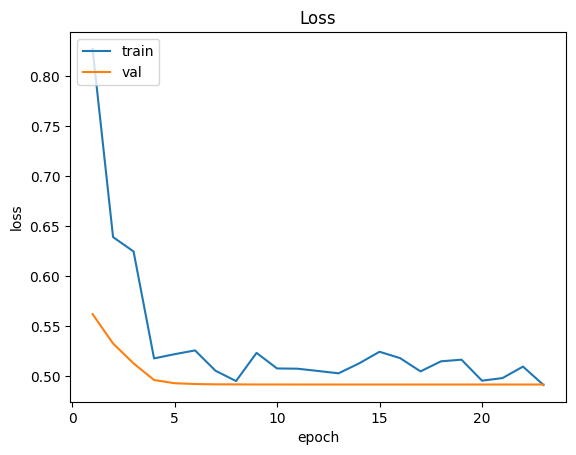

In [19]:
# draw Losses
if is_graphic:
    plt.plot(list(range(1, len(arr_train_loss) + 1)), arr_train_loss, label="train")
    plt.plot(list(range(1, len(arr_val_loss) + 1)), arr_val_loss, label="val")

    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(loc="upper left")

    plt.show()

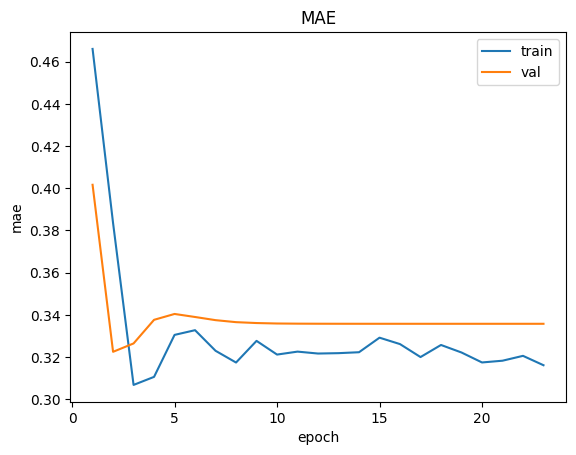

In [20]:
# draw mae
if is_graphic:
    plt.plot(list(range(1, len(arr_train_mae) + 1)), arr_train_mae, label="train")
    plt.plot(list(range(1, len(arr_val_mae) + 1)), arr_val_mae, label="val")

    plt.title("MAE")
    plt.xlabel("epoch")
    plt.ylabel("mae")
    plt.legend(loc="upper right")

    plt.show()

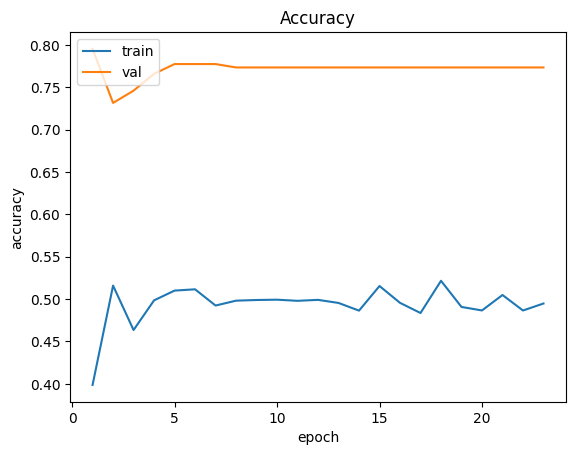

In [21]:
# draw Accuracies
if is_graphic:
    plt.plot(list(range(1, len(arr_train_acc) + 1)), arr_train_acc, label="train")
    plt.plot(list(range(1, len(arr_val_acc) + 1)), arr_val_acc, label="val")

    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend(loc="upper left")

    plt.show()

# Eval model

In [22]:
from utils_french.split_all_docs import split_all_docs
from rouge_score import rouge_scorer
from utils_french.threshold_probs import threshold_probs_by_prop

In [23]:
model = RNN_RNN(device=device, vocab_size=vocab_size, word_embed=embmgr.getEmbeddings(), dim_word_embed=300)

In [24]:
best_epoch = np.argmin(np.array(arr_val_loss)) + 1
model.load(checkpoints_folder + "/" + model_name + "-" + str(best_epoch) + ".pt")
model.to(device)
model.eval()
best_epoch

20

In [25]:
test_set = df_test
test_set["doc_splited"] = split_all_docs(test_set["flat_contents"], False)

In [26]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
criterion = nn.BCELoss()
mae_fn = nn.L1Loss()

In [27]:
arr_rouge1 = []
arr_rouge2 = []
arr_rougeL = []
arr_loss = []
mae = []
accuracy = []

idx = 0
with tqdm(test_iter, unit="batch", total=len(test_iter)) as tepoch:
    for batch in tepoch:
        tepoch.set_description("Eval model")
        features = []
        doc_lens = []

        for j in range(1):
            doc_lens.append(len(batch[j]["docs"]))
            features = features + batch[j]["docs"]
                
        features = torch.tensor(features, dtype=torch.long).to(device)

        targets = [torch.tensor(batch[j]["labels"], dtype=torch.float) for j in range(1)]
        targets = torch.cat(targets)
        targets = targets.to(device)

        y_pred = model(features, doc_lens)
    
        loss = criterion(y_pred, targets)

        arr_loss.append(loss.item())

        doc = test_set["doc_splited"].iloc[idx]
        summaries = test_set["summaries"].iloc[idx]

        probs = np.array(y_pred.tolist()) # compute_probs(y_pred)
        probs_tensor = y_pred #torch.tensor(probs, dtype=torch.float).to(device)

        #probs = threshold_probs_by_nb(probs=probs, doc_lens=[probs.shape[0]], average_number_of_sentences_per_document=average_number_of_sentences_per_document)
        #probs = threshold_probs_by_prop(probs=probs, doc_lens=[probs.shape[0]], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document)
        indices = torch.argsort(y_pred, descending=True)

        y_pred_thresh = []

        txt = ""

        for i in range(min(len(doc), y_pred.shape[0])):
            txt = txt + ". " + doc[indices[i]]
            y_pred_thresh.append(indices[i])
            if len(txt) >= len(summaries):
                break

        y_pred_thresh.sort()

        txt = ""

        for i in y_pred_thresh:#range(min(len(doc), y_pred.shape[0])):
            txt = txt + ". " + doc[i]

        n = min(len(txt), len(summaries))

        while n < len(txt) and txt[n].isalnum():
            n += 1

        txt = txt[:n]

        #assert len(txt) - len(summaries) <= 20

        scores = scorer.score(summaries, txt)
        arr_rouge1.append(scores["rouge1"].recall)
        arr_rouge2.append(scores["rouge2"].recall)
        arr_rougeL.append(scores["rougeL"].recall)

        mae.append(mae_fn(probs_tensor, targets).item())

        accuracy.append(accuracy_nb_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=[len(probs)], average_number_of_sentences_per_document=average_number_of_sentences_per_document))
        #accuracy.append(accuracy_prop_sent_per_doc_fn(probs=probs, targets=targets.cpu().detach().numpy(), doc_lens=[len(probs)], average_proportion_of_sentences_per_document=average_proportion_of_sentences_per_document))

        tepoch.set_postfix(accuracy = np.mean(accuracy), mae = np.mean(mae), rouge1 = np.mean(arr_rouge1), rouge2 = np.mean(arr_rouge2), rougeL = np.mean(arr_rougeL))
        idx += 1

Eval model: 100%|██████████| 100/100 [00:01<00:00, 70.55batch/s, accuracy=0.754, mae=0.333, rouge1=0.262, rouge2=0.08, rougeL=0.163]  


In [29]:
test_metrics = {}
test_metrics["accuracy"] = np.mean(accuracy)
test_metrics["mae"]      = np.mean(mae)
test_metrics["rouge1"]   = np.mean(arr_rouge1)
test_metrics["rouge2"]   = np.mean(arr_rouge2)
test_metrics["rougeL"]   = np.mean(arr_rougeL)

# Save to file in JSON format

with open(checkpoints_folder + "/test_metrics.json", 'w') as fp:
    json.dump(test_metrics, fp)

In [ ]:
# Does not excute this cell if you want to execute the following cells.
import sys
sys.exit()

SystemExit: 

/home/raoufdine/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
